# 📈 Week 10 Trading Strategy: Advanced Time Series

---

## 🎯 Strategy Overview

**Building on Weeks 1-9 + Adding Week 10 Concepts:**
- All prior ML and Statistical concepts
- **NEW:** Advanced ARIMA modeling
- **NEW:** Vector Autoregression (VAR) for multi-asset
- **NEW:** Cointegration testing
- **NEW:** Pairs trading signals

**Strategy Logic:**
1. Test for cointegration between pairs
2. Use VAR for cross-asset prediction
3. Generate mean-reversion signals
4. Combine with regime awareness

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 3
ZSCORE_ENTRY = 2.0
ZSCORE_EXIT = 0.5

print("=" * 60)
print("📊 WEEK 10 TRADING STRATEGY: ADVANCED TIME SERIES")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Z-Score Entry: ±{ZSCORE_ENTRY}")

📊 WEEK 10 TRADING STRATEGY: ADVANCED TIME SERIES

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📅 Z-Score Entry: ±2.0


In [2]:
# ============================================================
# DATA LOADING & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()
log_prices = np.log(prices)

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading market data...
✅ Loaded 756 trading days


---

## 📊 Section 1: Stationarity & Cointegration Testing (Week 10 Concept)

**Key Concepts:**
- **Stationarity:** Mean and variance don't change over time
- **Cointegration:** Two non-stationary series that move together
- **Spread:** Linear combination that IS stationary

**Pairs trading exploits cointegration!**

In [3]:
# ============================================================
# STATIONARITY TESTING (ADF)
# ============================================================

print("📊 STATIONARITY TESTING (ADF Test)")
print("=" * 70)
print(f"\n{'Series':<15} {'ADF Stat':>12} {'p-value':>12} {'Stationary?':>15}")
print("-" * 70)

adf_results = {}
for ticker in TICKERS:
    # Test prices
    adf_price = adfuller(prices[ticker], maxlag=5, autolag='AIC')
    # Test returns
    adf_return = adfuller(returns[ticker].dropna(), maxlag=5, autolag='AIC')
    
    adf_results[ticker] = {
        'price_stat': adf_price[0],
        'price_pval': adf_price[1],
        'return_stat': adf_return[0],
        'return_pval': adf_return[1]
    }
    
    stationary = "✅ YES" if adf_price[1] < 0.05 else "❌ NO"
    print(f"{ticker} (Price)   {adf_price[0]:>11.3f} {adf_price[1]:>11.4f} {stationary:>15}")
    print(f"{ticker} (Return)  {adf_return[0]:>11.3f} {adf_return[1]:>11.4f} {'✅ YES':>15}")

📊 STATIONARITY TESTING (ADF Test)

Series              ADF Stat      p-value     Stationary?
----------------------------------------------------------------------
AAPL (Price)        -1.660      0.4520            ❌ NO
AAPL (Return)      -13.983      0.0000           ✅ YES
MSFT (Price)        -2.213      0.2015            ❌ NO
MSFT (Return)      -28.006      0.0000           ✅ YES
GOOGL (Price)         1.361      0.9969            ❌ NO
GOOGL (Return)      -27.235      0.0000           ✅ YES
AMZN (Price)        -1.514      0.5266            ❌ NO
AMZN (Return)      -21.469      0.0000           ✅ YES
META (Price)        -1.817      0.3719            ❌ NO
META (Return)      -28.286      0.0000           ✅ YES


In [4]:
# ============================================================
# COINTEGRATION TESTING
# ============================================================

print("\n📊 COINTEGRATION TESTING (All Pairs)")
print("=" * 80)

pairs = list(combinations(TICKERS, 2))
coint_results = []

print(f"\n{'Pair':<20} {'t-stat':>12} {'p-value':>12} {'Cointegrated?':>15}")
print("-" * 80)

for pair in pairs:
    ticker1, ticker2 = pair
    
    # Engle-Granger cointegration test
    score, pvalue, _ = coint(log_prices[ticker1], log_prices[ticker2])
    
    is_coint = pvalue < 0.05
    coint_results.append({
        'pair': f"{ticker1}-{ticker2}",
        'ticker1': ticker1,
        'ticker2': ticker2,
        't_stat': score,
        'p_value': pvalue,
        'cointegrated': is_coint
    })
    
    status = "✅ YES" if is_coint else "❌ NO"
    print(f"{ticker1}-{ticker2:<12} {score:>11.3f} {pvalue:>11.4f} {status:>15}")

coint_df = pd.DataFrame(coint_results)
cointegrated_pairs = coint_df[coint_df['cointegrated'] == True]

print(f"\n✅ Found {len(cointegrated_pairs)} cointegrated pairs out of {len(pairs)}")


📊 COINTEGRATION TESTING (All Pairs)

Pair                       t-stat      p-value   Cointegrated?
--------------------------------------------------------------------------------
AAPL-MSFT              -2.133      0.4593            ❌ NO
AAPL-GOOGL             -2.970      0.1176            ❌ NO
AAPL-AMZN              -2.715      0.1943            ❌ NO
AAPL-META              -1.929      0.5650            ❌ NO
MSFT-GOOGL             -1.260      0.8415            ❌ NO
MSFT-AMZN              -3.160      0.0768            ❌ NO
MSFT-META              -2.665      0.2125            ❌ NO
GOOGL-AMZN              -0.530      0.9621            ❌ NO
GOOGL-META               0.243      0.9902            ❌ NO
AMZN-META              -4.441      0.0015           ✅ YES

✅ Found 1 cointegrated pairs out of 10


In [5]:
# ============================================================
# SPREAD ANALYSIS FOR COINTEGRATED PAIRS
# ============================================================

print("\n📊 SPREAD ANALYSIS (Best Pairs)")
print("=" * 80)

def analyze_spread(prices, ticker1, ticker2, window=60):
    """Calculate and analyze the spread."""
    # Calculate hedge ratio using OLS
    from scipy import stats
    slope, intercept, _, _, _ = stats.linregress(prices[ticker2], prices[ticker1])
    
    # Calculate spread
    spread = prices[ticker1] - slope * prices[ticker2]
    
    # Z-score
    spread_mean = spread.rolling(window).mean()
    spread_std = spread.rolling(window).std()
    zscore = (spread - spread_mean) / spread_std
    
    # Half-life of mean reversion
    spread_lag = spread.shift(1)
    spread_diff = spread - spread_lag
    
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    valid_idx = ~(spread_lag.isna() | spread_diff.isna())
    model.fit(spread_lag[valid_idx].values.reshape(-1, 1), spread_diff[valid_idx].values)
    half_life = -np.log(2) / model.coef_[0] if model.coef_[0] < 0 else np.inf
    
    return {
        'hedge_ratio': slope,
        'spread': spread,
        'zscore': zscore,
        'half_life': half_life,
        'current_zscore': zscore.iloc[-1],
        'spread_std': spread_std.iloc[-1]
    }

# Analyze top pairs (by p-value)
spread_results = {}
top_pairs = coint_df.nsmallest(3, 'p_value')

for _, row in top_pairs.iterrows():
    pair_name = row['pair']
    result = analyze_spread(prices, row['ticker1'], row['ticker2'])
    spread_results[pair_name] = result
    
    print(f"\n{pair_name}:")
    print(f"   Hedge Ratio: {result['hedge_ratio']:.4f}")
    print(f"   Half-Life: {result['half_life']:.1f} days")
    print(f"   Current Z-Score: {result['current_zscore']:.2f}")


📊 SPREAD ANALYSIS (Best Pairs)

AMZN-META:
   Hedge Ratio: 0.2371
   Half-Life: 23.6 days
   Current Z-Score: 0.22

MSFT-AMZN:
   Hedge Ratio: 1.5767
   Half-Life: 38.4 days
   Current Z-Score: -1.90

AAPL-GOOGL:
   Hedge Ratio: 0.5602
   Half-Life: 50.8 days
   Current Z-Score: -2.33


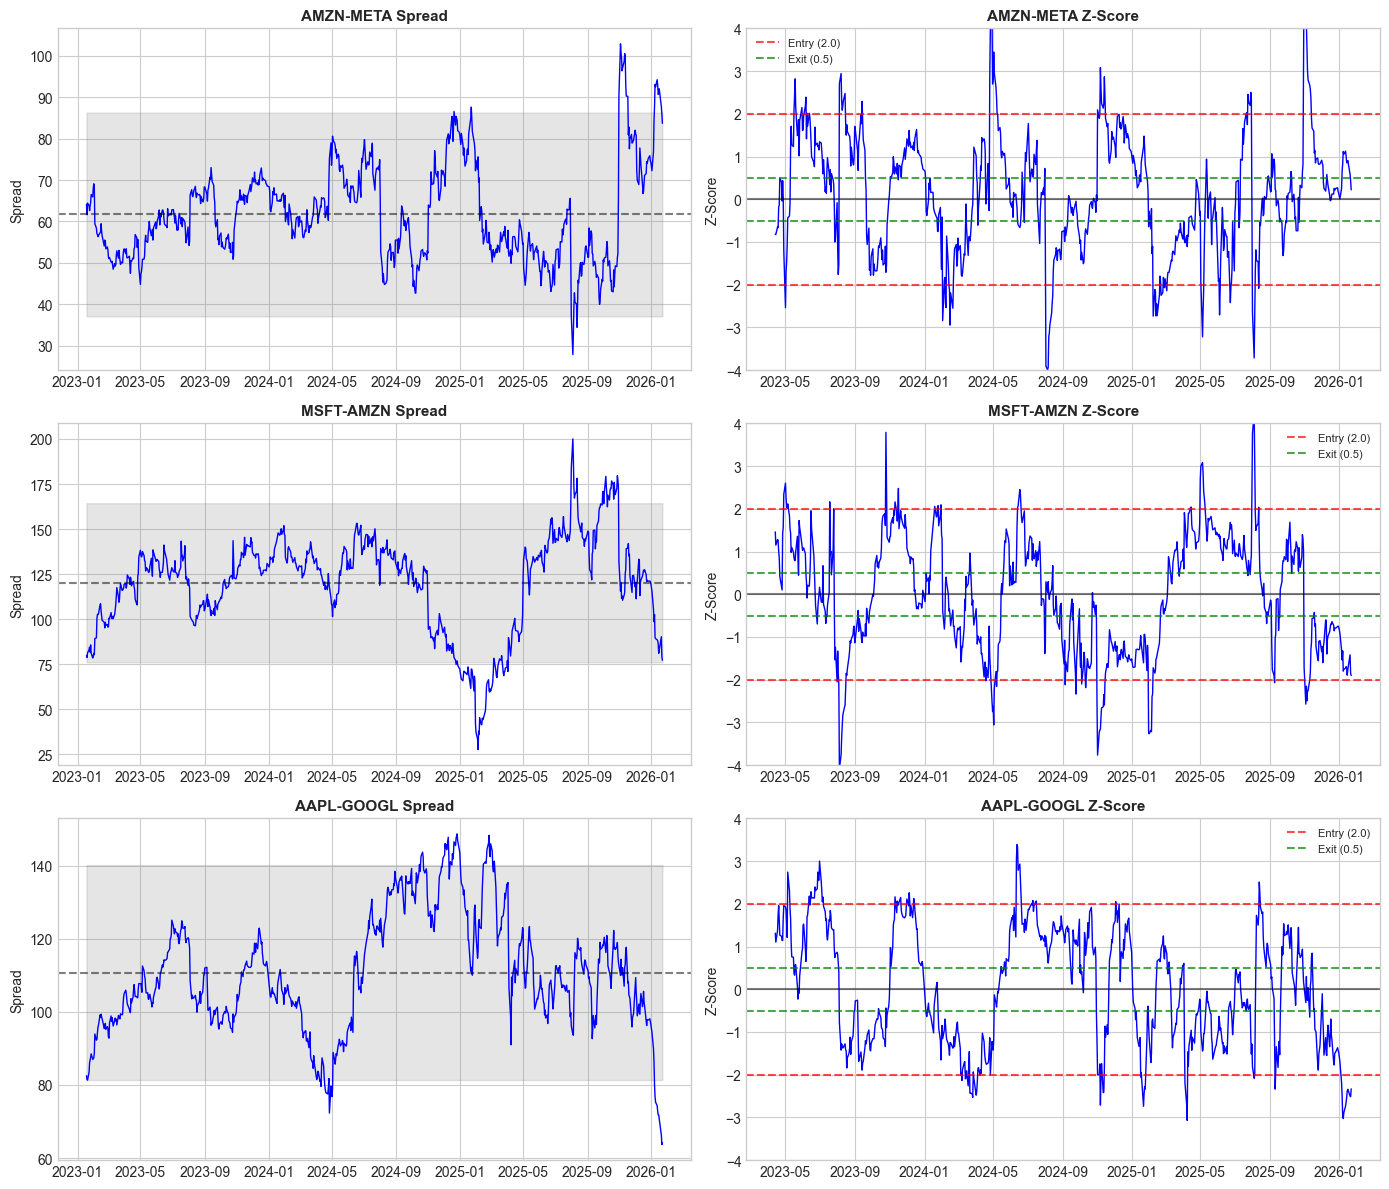

In [6]:
# ============================================================
# SPREAD VISUALIZATION
# ============================================================

if len(spread_results) > 0:
    fig, axes = plt.subplots(len(spread_results), 2, figsize=(14, 4*len(spread_results)))
    
    if len(spread_results) == 1:
        axes = [axes]
    
    for i, (pair, result) in enumerate(spread_results.items()):
        # Spread
        ax1 = axes[i][0]
        ax1.plot(result['spread'], 'b-', linewidth=1)
        ax1.axhline(y=result['spread'].mean(), color='k', linestyle='--', alpha=0.5)
        ax1.fill_between(result['spread'].index, 
                        result['spread'].mean() - 2*result['spread_std'],
                        result['spread'].mean() + 2*result['spread_std'],
                        alpha=0.2, color='gray')
        ax1.set_title(f'{pair} Spread', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Spread')
        
        # Z-Score
        ax2 = axes[i][1]
        ax2.plot(result['zscore'], 'b-', linewidth=1)
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.5)
        ax2.axhline(y=ZSCORE_ENTRY, color='r', linestyle='--', alpha=0.7, label=f'Entry ({ZSCORE_ENTRY})')
        ax2.axhline(y=-ZSCORE_ENTRY, color='r', linestyle='--', alpha=0.7)
        ax2.axhline(y=ZSCORE_EXIT, color='g', linestyle='--', alpha=0.7, label=f'Exit ({ZSCORE_EXIT})')
        ax2.axhline(y=-ZSCORE_EXIT, color='g', linestyle='--', alpha=0.7)
        ax2.set_title(f'{pair} Z-Score', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Z-Score')
        ax2.legend(fontsize=8)
        ax2.set_ylim(-4, 4)
    
    plt.tight_layout()
    plt.show()

---

## 📊 Section 2: Vector Autoregression (VAR) (Week 10 Concept)

**VAR models cross-asset dynamics:**
$$y_t = c + A_1 y_{t-1} + A_2 y_{t-2} + ... + \epsilon_t$$

**Each asset's return depends on ALL assets' past returns!**

In [7]:
# ============================================================
# VAR MODEL
# ============================================================

print("\n📊 VECTOR AUTOREGRESSION (VAR) ANALYSIS")
print("=" * 70)

# Prepare data for VAR
returns_var = returns[TICKERS].dropna() * 100  # Scale for numerical stability

# Fit VAR model
var_model = VAR(returns_var)
var_result = var_model.fit(maxlags=5, ic='aic')

print(f"\n✅ VAR Model Summary:")
print(f"   Optimal Lag Order: {var_result.k_ar}")
print(f"   AIC: {var_result.aic:.2f}")
print(f"   BIC: {var_result.bic:.2f}")

# Forecast
var_forecast = var_result.forecast(returns_var.values[-var_result.k_ar:], steps=5)
var_forecast_df = pd.DataFrame(var_forecast, columns=TICKERS)

print(f"\n📈 VAR FORECASTS (5-Day, cumulative %):")
for ticker in TICKERS:
    cum_forecast = var_forecast_df[ticker].sum()
    print(f"   {ticker}: {cum_forecast:>8.2f}%")


📊 VECTOR AUTOREGRESSION (VAR) ANALYSIS

✅ VAR Model Summary:
   Optimal Lag Order: 1
   AIC: 4.20
   BIC: 4.39

📈 VAR FORECASTS (5-Day, cumulative %):
   AAPL:     0.52%
   MSFT:     0.40%
   GOOGL:     0.73%
   AMZN:     0.05%
   META:     0.98%



📊 CROSS-ASSET DEPENDENCIES (VAR Coefficients)

📈 Lag-1 Coefficients (row = current, col = past):
       AAPL_L1  MSFT_L1  GOOGL_L1  AMZN_L1  META_L1
AAPL     0.076   -0.050     0.007   -0.002    0.001
MSFT    -0.051    0.017    -0.030    0.037   -0.021
GOOGL   -0.087    0.011     0.046    0.042   -0.054
AMZN    -0.066   -0.023     0.029    0.112   -0.192
META    -0.108    0.095     0.002    0.021   -0.047


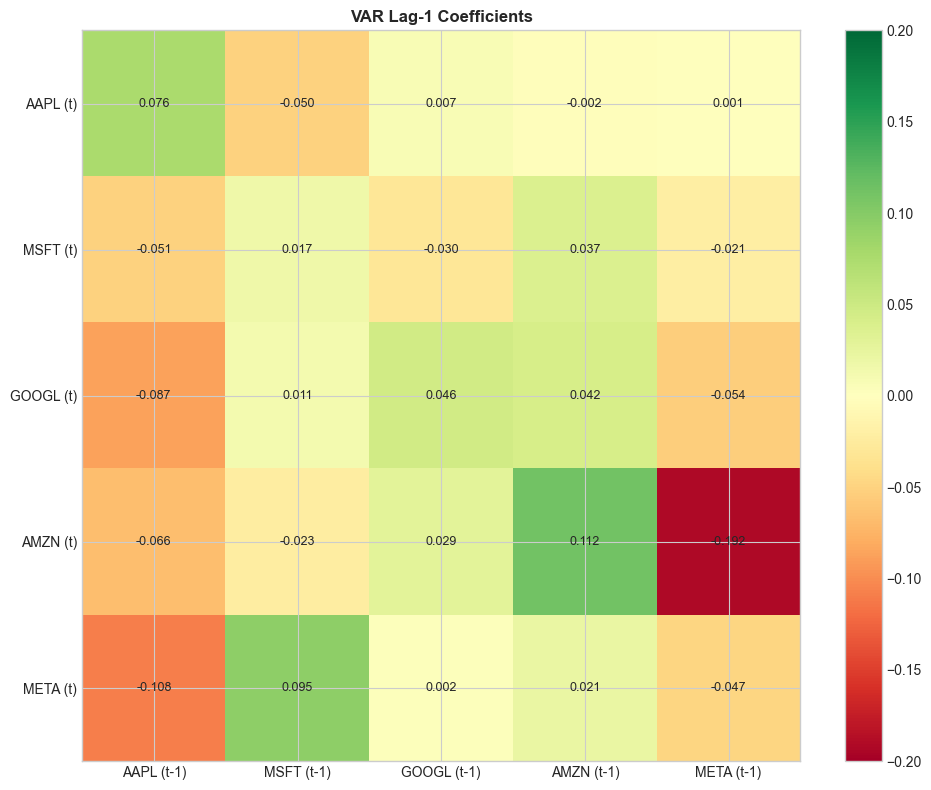

In [8]:
# ============================================================
# GRANGER CAUSALITY (IMPLIED BY VAR)
# ============================================================

print("\n📊 CROSS-ASSET DEPENDENCIES (VAR Coefficients)")
print("=" * 70)

# Get coefficient matrix for lag 1
coef_matrix = pd.DataFrame(
    var_result.coefs[0],
    index=TICKERS,
    columns=[f'{t}_L1' for t in TICKERS]
)

print("\n📈 Lag-1 Coefficients (row = current, col = past):")
print(coef_matrix.round(3).to_string())

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(coef_matrix.values, cmap='RdYlGn', aspect='auto', vmin=-0.2, vmax=0.2)
ax.set_xticks(range(len(TICKERS)))
ax.set_yticks(range(len(TICKERS)))
ax.set_xticklabels([f'{t} (t-1)' for t in TICKERS])
ax.set_yticklabels([f'{t} (t)' for t in TICKERS])
ax.set_title('VAR Lag-1 Coefficients', fontsize=12, fontweight='bold')
for i in range(len(TICKERS)):
    for j in range(len(TICKERS)):
        ax.text(j, i, f'{coef_matrix.iloc[i, j]:.3f}', ha='center', va='center', fontsize=9)
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# ARIMA FOR INDIVIDUAL STOCKS
# ============================================================

print("\n📊 ARIMA FORECASTS (Per Stock)")
print("=" * 70)

arima_results = {}

print(f"\n{'Ticker':<10} {'Order':>15} {'AIC':>12} {'Forecast (5d)':>15}")
print("-" * 70)

for ticker in TICKERS:
    try:
        # Fit ARIMA with automatic order selection
        model = ARIMA(returns[ticker].dropna() * 100, order=(1, 0, 1))
        result = model.fit()
        
        # Forecast
        forecast = result.get_forecast(steps=5)
        forecast_mean = forecast.predicted_mean.sum()
        
        arima_results[ticker] = {
            'model': result,
            'order': (1, 0, 1),
            'aic': result.aic,
            'forecast': forecast_mean
        }
        
        print(f"{ticker:<10} {'(1,0,1)':>15} {result.aic:>11.2f} {forecast_mean:>14.2f}%")
    except Exception as e:
        arima_results[ticker] = {'forecast': 0, 'error': str(e)}
        print(f"{ticker:<10} {'ERROR':>15}")


📊 ARIMA FORECASTS (Per Stock)

Ticker               Order          AIC   Forecast (5d)
----------------------------------------------------------------------
AAPL               (1,0,1)     2864.98           0.54%
MSFT               (1,0,1)     2708.09           0.61%
GOOGL              (1,0,1)     3120.32           0.96%
AMZN               (1,0,1)     3188.08           1.00%
META               (1,0,1)     3472.08           0.96%


In [10]:
# ============================================================
# TRADING SIGNALS
# ============================================================

print("\n📊 TIME SERIES TRADING SIGNALS")
print("=" * 90)

# Combine signals
trading_signals = {}

for ticker in TICKERS:
    # VAR forecast
    var_forecast_val = var_forecast_df[ticker].sum()
    
    # ARIMA forecast
    arima_forecast_val = arima_results[ticker].get('forecast', 0)
    
    # Ensemble
    ensemble_forecast = 0.5 * var_forecast_val + 0.5 * arima_forecast_val
    
    # Signal
    if ensemble_forecast > 1.0:
        signal = 'STRONG LONG'
    elif ensemble_forecast > 0.3:
        signal = 'LONG'
    elif ensemble_forecast < -1.0:
        signal = 'STRONG SHORT'
    elif ensemble_forecast < -0.3:
        signal = 'SHORT'
    else:
        signal = 'NEUTRAL'
    
    trading_signals[ticker] = {
        'var_forecast': var_forecast_val,
        'arima_forecast': arima_forecast_val,
        'ensemble': ensemble_forecast,
        'signal': signal
    }

print(f"\n{'Ticker':<10} {'VAR Fcst':>12} {'ARIMA Fcst':>12} {'Ensemble':>12} {'Signal':>15}")
print("-" * 90)
for ticker, data in trading_signals.items():
    signal_emoji = "📈📈" if 'STRONG LONG' in data['signal'] else ("📈" if 'LONG' in data['signal'] else ("📉📉" if 'STRONG SHORT' in data['signal'] else ("📉" if 'SHORT' in data['signal'] else "⚪")))
    print(f"{ticker:<10} {data['var_forecast']:>11.2f}% {data['arima_forecast']:>11.2f}% {data['ensemble']:>11.2f}% {signal_emoji} {data['signal']:<10}")


📊 TIME SERIES TRADING SIGNALS

Ticker         VAR Fcst   ARIMA Fcst     Ensemble          Signal
------------------------------------------------------------------------------------------
AAPL              0.52%        0.54%        0.53% 📈 LONG      
MSFT              0.40%        0.61%        0.51% 📈 LONG      
GOOGL             0.73%        0.96%        0.85% 📈 LONG      
AMZN              0.05%        1.00%        0.53% 📈 LONG      
META              0.98%        0.96%        0.97% 📈 LONG      


In [11]:
# ============================================================
# PAIRS TRADING SIGNALS
# ============================================================

print("\n📊 PAIRS TRADING SIGNALS")
print("=" * 80)

pairs_signals = {}

if len(spread_results) > 0:
    print(f"\n{'Pair':<20} {'Z-Score':>12} {'Signal':>15} {'Action':>25}")
    print("-" * 80)
    
    for pair, result in spread_results.items():
        zscore = result['current_zscore']
        
        if zscore > ZSCORE_ENTRY:
            signal = 'SHORT SPREAD'
            action = f'Short {pair.split("-")[0]}, Long {pair.split("-")[1]}'
        elif zscore < -ZSCORE_ENTRY:
            signal = 'LONG SPREAD'
            action = f'Long {pair.split("-")[0]}, Short {pair.split("-")[1]}'
        elif abs(zscore) < ZSCORE_EXIT:
            signal = 'CLOSE'
            action = 'Exit position'
        else:
            signal = 'HOLD'
            action = 'Maintain position'
        
        pairs_signals[pair] = {
            'zscore': zscore,
            'signal': signal,
            'action': action,
            'half_life': result['half_life']
        }
        
        signal_emoji = "📉" if 'SHORT' in signal else ("📈" if 'LONG' in signal else "⚪")
        print(f"{pair:<20} {zscore:>11.2f} {signal_emoji} {signal:<12} {action:<25}")


📊 PAIRS TRADING SIGNALS

Pair                      Z-Score          Signal                    Action
--------------------------------------------------------------------------------
AMZN-META                   0.22 ⚪ CLOSE        Exit position            
MSFT-AMZN                  -1.90 ⚪ HOLD         Maintain position        
AAPL-GOOGL                 -2.33 📈 LONG SPREAD  Long AAPL, Short GOOGL   


In [12]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 10 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Summary
print("\n📋 TIME SERIES ANALYSIS SUMMARY:")

# Directional signals
print(f"\n🎯 DIRECTIONAL SIGNALS (VAR + ARIMA Ensemble):")
for ticker in TICKERS:
    data = trading_signals[ticker]
    print(f"   {ticker}: {data['ensemble']:.2f}% → {data['signal']}")

# Best directional trade
best_long = max(trading_signals, key=lambda x: trading_signals[x]['ensemble'])
best_short = min(trading_signals, key=lambda x: trading_signals[x]['ensemble'])

print(f"\n🏆 BEST DIRECTIONAL TRADES:")
print(f"   📈 LONG: {best_long} (Expected: {trading_signals[best_long]['ensemble']:.2f}%)")
print(f"   📉 SHORT: {best_short} (Expected: {trading_signals[best_short]['ensemble']:.2f}%)")

# Pairs trading
if len(pairs_signals) > 0:
    print(f"\n🔄 PAIRS TRADING SIGNALS:")
    for pair, data in pairs_signals.items():
        if data['signal'] != 'HOLD':
            print(f"   {pair}: {data['signal']} (Z={data['zscore']:.2f}, HL={data['half_life']:.0f}d)")
            print(f"      Action: {data['action']}")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 10 STRATEGY - FINAL RECOMMENDATIONS

📋 TIME SERIES ANALYSIS SUMMARY:

🎯 DIRECTIONAL SIGNALS (VAR + ARIMA Ensemble):
   AAPL: 0.53% → LONG
   MSFT: 0.51% → LONG
   GOOGL: 0.85% → LONG
   AMZN: 0.53% → LONG
   META: 0.97% → LONG

🏆 BEST DIRECTIONAL TRADES:
   📈 LONG: META (Expected: 0.97%)
   📉 SHORT: MSFT (Expected: 0.51%)

🔄 PAIRS TRADING SIGNALS:
   AMZN-META: CLOSE (Z=0.22, HL=24d)
      Action: Exit position
   AAPL-GOOGL: LONG SPREAD (Z=-2.33, HL=51d)
      Action: Long AAPL, Short GOOGL

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-10)

| Week | Concept | Application |
|------|---------|-------------|
| 1-9 | Prior Concepts | Foundation |
| **10** | **Cointegration** | **Pairs trading** |
| **10** | **VAR** | **Cross-asset prediction** |
| **10** | **ARIMA** | **Individual forecasts** |
| **10** | **Spread Z-Score** | **Mean reversion signals** |

---